In [1]:
import numpy as np
import random
import gym as gym
import d4rl
from collections import deque
import os
import pickle

/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
No module named 'flow'
/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Jan 29 2025 23:19:57


In [2]:
# env = gym.make('hopper-medium-v2')
# ho_dataset = env.get_dataset()
# with open('/public/d4rl/hopper-medium-v2.pkl', 'wb') as f:
#         pickle.dump(ho_dataset, f)
# env = gym.make('halfcheetah-medium-v2')
# ha_dataset = env.get_dataset()
# with open('/public/d4rl/halfcheetah-medium-v2.pkl', 'wb') as f:
#         pickle.dump(ha_dataset, f)
env = gym.make('walker2d-medium-v2')
wa_dataset = env.get_dataset()

# env = gym.make('hopper-medium-v2')
# ho_dataset = env.get_dataset()

# env = gym.make('halfcheetah-medium-v2')
# ha_dataset = env.get_dataset()
# with open('/public/d4rl/walker2d-medium-v2.pkl', 'wb') as f:
#         pickle.dump(wa_dataset, f)
# env = gym.make('halfcheetah-medium-v2')
# ha_dataset = env.get_dataset()

/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

load datafile:  19%|█▉        | 4/21 [00:01<00:05,  3.16it/s]/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
load datafile: 100%|██████████| 21/21 [07:51<00:00, 22.47s/it]


In [3]:
import numpy as np
import random

def select_subset_and_add_noise(
    dataset,
    num_trajectories=50,
    noise_std=0.1,
    noise_mean=0.0,
    num_samples=10000,
    use_timeouts=True,
    clip_actions=True,
    action_low=-1.0,
    action_high=1.0,
    seed=None,
):
    rng = np.random.default_rng(seed)

    obs = dataset["observations"]
    acts = dataset["actions"]
    rews = dataset["rewards"]
    terms = dataset.get("terminals", np.zeros(len(rews), dtype=bool))

    if use_timeouts and ("timeouts" in dataset):
        ends = np.logical_or(terms.astype(bool), dataset["timeouts"].astype(bool))
    else:
        ends = terms.astype(bool)

    # Build (start, end) episode index ranges
    traj_indices = []
    start = 0
    for i, done in enumerate(ends):
        if done:
            traj_indices.append((start, i + 1))
            start = i + 1

    # Fallback: if no episode boundaries exist, just slice first num_samples transitions
    if len(traj_indices) == 0:
        idx = slice(0, min(num_samples, len(rews)))
        traj_obs = obs[idx]
        traj_acts = acts[idx]
        traj_rews = rews[idx]
        traj_ends = ends[idx]

        noise_obs = rng.normal(loc=noise_mean, scale=noise_std, size=traj_obs.shape)
        noise_act = rng.normal(loc=noise_mean, scale=noise_std, size=traj_acts.shape)

        new_obs = traj_obs + noise_obs
        new_acts = traj_acts + noise_act

        if clip_actions:
            new_acts = np.clip(new_acts, action_low, action_high)

        new_dataset = dict(observations=new_obs, actions=new_acts, rewards=traj_rews, terminals=traj_ends)
        orig_dataset = dict(observations=traj_obs, actions=traj_acts, rewards=traj_rews, terminals=traj_ends)
        return new_dataset, orig_dataset

    # Sample trajectories
    k = min(num_trajectories, len(traj_indices))
    selected = random.sample(traj_indices, k)

    new_obs_list, new_act_list, new_rew_list, new_end_list = [], [], [], []
    old_obs_list, old_act_list = [], []

    for s, e in selected:
        traj_obs = obs[s:e]
        traj_acts = acts[s:e]
        traj_rews = rews[s:e]
        traj_ends = ends[s:e]

        noise_obs = rng.normal(loc=noise_mean, scale=noise_std, size=traj_obs.shape)
        noise_act = rng.normal(loc=noise_mean, scale=noise_std, size=traj_acts.shape)

        traj_obs_noisy = traj_obs + noise_obs
        traj_acts_noisy = traj_acts + noise_act

        if clip_actions:
            traj_acts_noisy = np.clip(traj_acts_noisy, action_low, action_high)

        new_obs_list.append(traj_obs_noisy)
        new_act_list.append(traj_acts_noisy)
        new_rew_list.append(traj_rews)
        new_end_list.append(traj_ends)
        old_obs_list.append(traj_obs)
        old_act_list.append(traj_acts)

    new_dataset = {
        "observations": np.concatenate(new_obs_list, axis=0),
        "actions": np.concatenate(new_act_list, axis=0),
        "rewards": np.concatenate(new_rew_list, axis=0),
        "terminals": np.concatenate(new_end_list, axis=0),
    }
    orig_dataset = {
        "observations": np.concatenate(old_obs_list, axis=0),
        "actions": np.concatenate(old_act_list, axis=0),
        "rewards": new_dataset["rewards"],
        "terminals": new_dataset["terminals"],
    }
    return new_dataset, orig_dataset


In [4]:
#tsne visualization of the original and ood concatenated observations and actions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(normal_data, ood_data, noise_mean=10):
    normal_obs = normal_data['observations']
    normal_acts = normal_data['actions']
    ood_obs = ood_data['observations']
    ood_acts = ood_data['actions']
    
    normal_concat = np.concatenate([normal_obs, normal_acts], axis=1)
    ood_concat = np.concatenate([ood_obs, ood_acts], axis=1)
    
    combined_data = np.concatenate([normal_concat, ood_concat], axis=0)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(combined_data)
    
    normal_tsne = tsne_results[:len(normal_concat)]
    ood_tsne = tsne_results[len(normal_concat):]
    
    plt.figure(figsize=(10, 7))
    plt.scatter(normal_tsne[:, 0], normal_tsne[:, 1], label='Normal Data', alpha=0.5)
    plt.scatter(ood_tsne[:, 0], ood_tsne[:, 1], label='OOD Data', alpha=0.5)
    plt.legend()
    plt.title(f't-SNE Visualization of Normal and OOD Data with distance {noise_mean}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [5]:
#concatenate ood_data_5 and normal and save in /public/d4rl/ood_test/walker2d-medium-v2/-ood-distance-5.pkl
def save_combined_dataset(normal, ood_data, d_name, distance):
    
    combined_data = {
        'observations': np.concatenate([normal['observations'], ood_data['observations']]),
        'actions': np.concatenate([normal['actions'], ood_data['actions']]),
        'rewards': np.concatenate([normal['rewards'], ood_data['rewards']]),
        'terminals': np.concatenate([normal['terminals'], ood_data['terminals']])
    }
    os.makedirs(f'/public/d4rl/ood_test/{d_name}/', exist_ok=True)
    with open(f'/public/d4rl/ood_test/{d_name}/ood-distance-{str(distance)}.pkl', 'wb') as f:
        pickle.dump(combined_data, f)




In [6]:
# ood_data_5, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.1)
# ood_data_10, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.3)
# ood_data_15, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.5)
# ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.7)
ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)

# # ood_data_07, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
# save_combined_dataset(normal, ood_data_5, 'walker2d-medium-v2' , 0.1)
# save_combined_dataset(normal, ood_data_10, 'walker2d-medium-v2', 0.3)
# save_combined_dataset(normal, ood_data_15, 'walker2d-medium-v2', 0.5)
# save_combined_dataset(normal, ood_data_20,'walker2d-medium-v2', 0.7)
save_combined_dataset(normal, ood_data_20,'walker2d-medium-v2', 1)

In [68]:
ood_data_5, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.1)
ood_data_10, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.3)
ood_data_15, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.5)
ood_data_20, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.7)

ood_data_07, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
save_combined_dataset(normal, ood_data_5, 'hopper-medium-v2' , 0.1)
save_combined_dataset(normal, ood_data_10, 'hopper-medium-v2', 0.3)
save_combined_dataset(normal, ood_data_15, 'hopper-medium-v2', 0.5)
save_combined_dataset(normal, ood_data_20,'hopper-medium-v2', 0.7)
save_combined_dataset(normal, ood_data_07,'hopper-medium-v2', 1)

In [56]:
ood_data_01, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.1)
ood_data_03, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.3)
ood_data_05, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.5)
ood_data_07, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.7)
ood_data_1, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)


save_combined_dataset(normal, ood_data_01, 'halfcheetah-medium-v2' , 0.1)
save_combined_dataset(normal, ood_data_03, 'halfcheetah-medium-v2', 0.3)
save_combined_dataset(normal, ood_data_05, 'halfcheetah-medium-v2', 0.5)
save_combined_dataset(normal, ood_data_07, 'halfcheetah-medium-v2', 0.7)

save_combined_dataset(normal, ood_data_1,'halfcheetah-medium-v2', 1)

In [6]:
ood_data_01, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 5)
ood_data_03, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 10)
ood_data_05, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 15)


save_combined_dataset(normal, ood_data_01, 'halfcheetah-medium-v2' , 5)
save_combined_dataset(normal, ood_data_03, 'halfcheetah-medium-v2', 10)
save_combined_dataset(normal, ood_data_05, 'halfcheetah-medium-v2', 15)


In [49]:
ood_data_5, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)
ood_data_10, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 10)
ood_data_15, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 15)
ood_data_20, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 20)

save_combined_dataset(normal, ood_data_5, 'hopper-medium-v2,' , 5)
save_combined_dataset(normal, ood_data_10, 'hopper-medium-v2', 10)
save_combined_dataset(normal, ood_data_15, 'hopper-medium-v2', 15)
save_combined_dataset(normal, ood_data_20,'hopper-medium-v2', 20)

In [14]:
ood_data, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)

In [23]:
ood_data_10=ood_data

In [24]:
ood_data_5, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)

In [30]:
ood_data_15, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 15)

In [34]:
ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 20)

In [36]:
ood_data_40, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 40)

In [ ]:
save_combined_dataset(normal, ood_data_5, 5)
save_combined_dataset(normal, ood_data_10, 10)
save_combined_dataset(normal, ood_data_15, 15)
save_combined_dataset(normal, ood_data_20, 20)

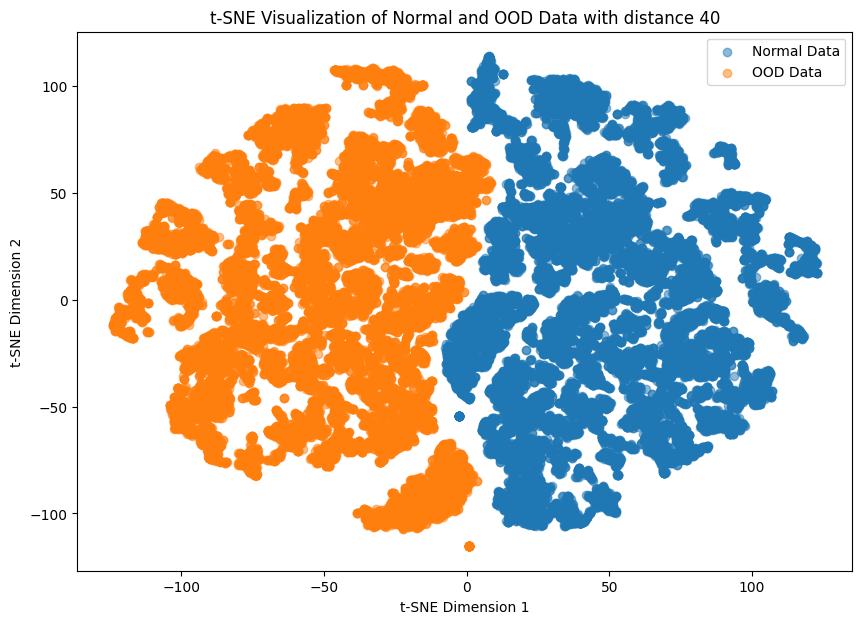

In [37]:
plot_tsne(normal, ood_data_40, noise_mean = 40)

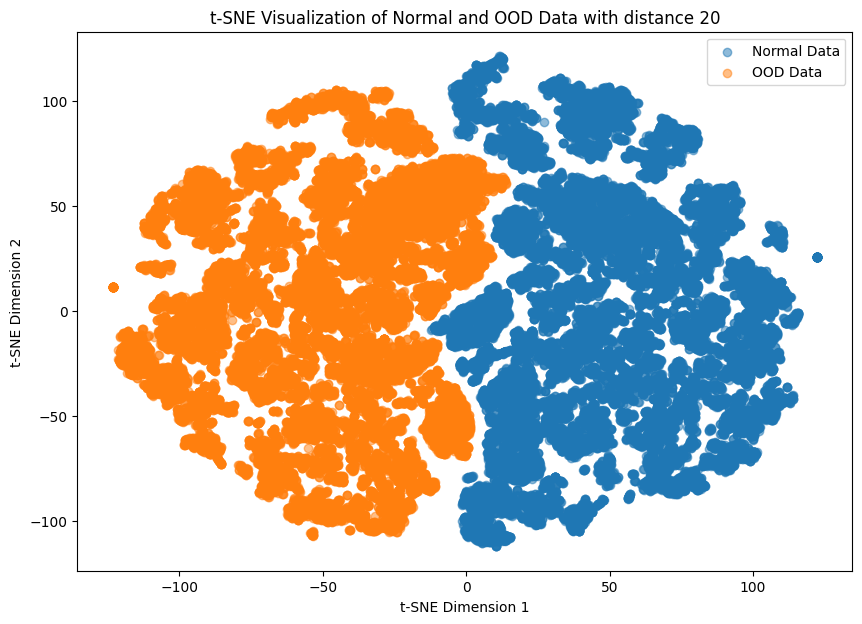

In [35]:
plot_tsne(normal, ood_data_20, noise_mean = 20)

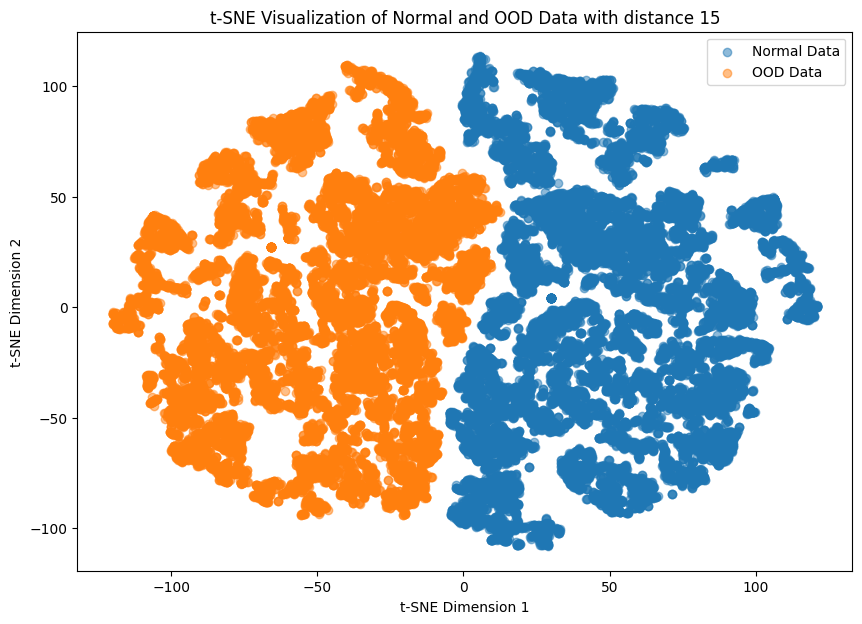

In [31]:
plot_tsne(normal, ood_data_15, noise_mean = 15)

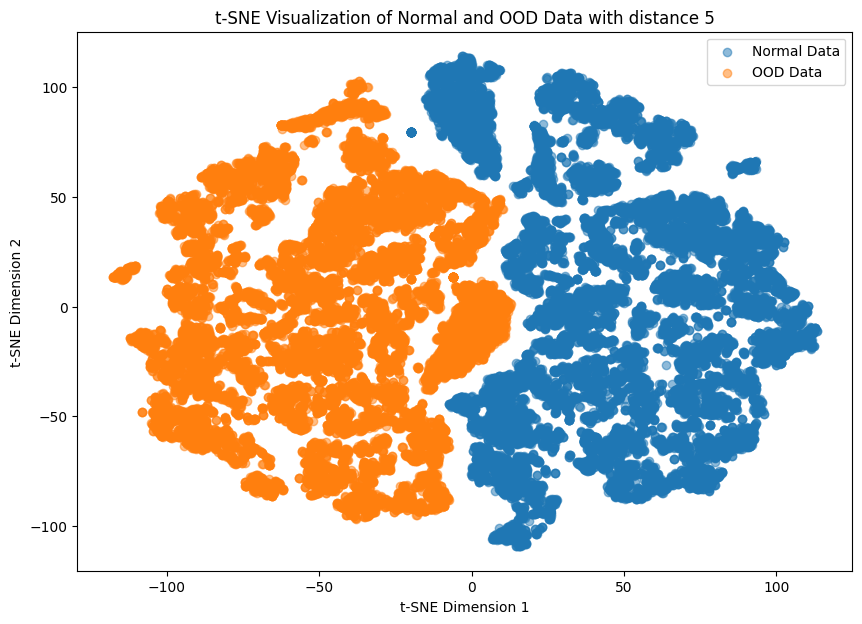

In [29]:
plot_tsne(normal, ood_data_5, noise_mean =5)

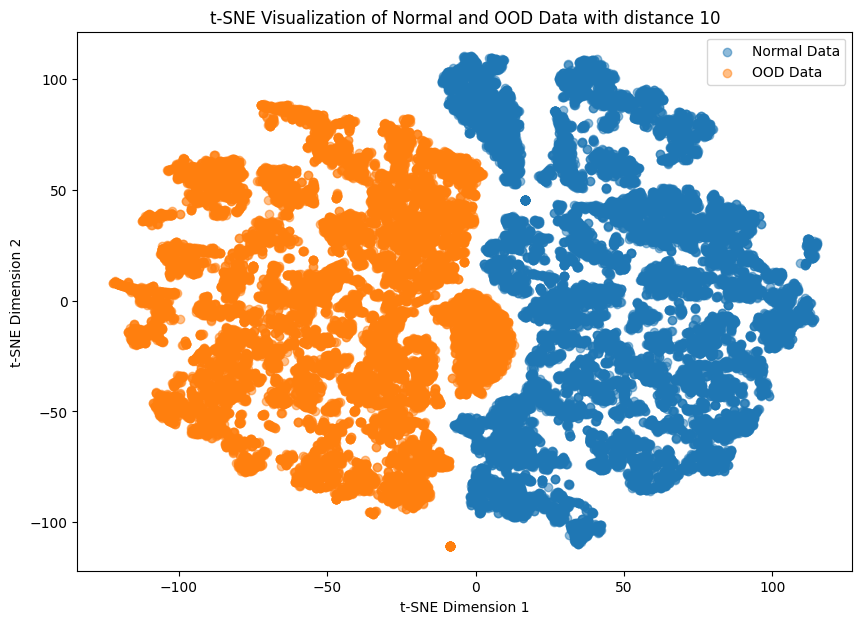

In [27]:
plot_tsne(normal, ood_data, noise_mean =10)

In [17]:
from scipy.stats import wasserstein_distance
def compute_wasserstein_distance(normal_data, ood_data):
    distances = {}
    normal_obs = normal_data['observations']
    normal_acts = normal_data['actions']
    ood_obs = ood_data['observations']
    ood_acts = ood_data['actions']

    normal_concat = np.concatenate([normal_obs, normal_acts], axis=1).flatten()
    ood_concat = np.concatenate([ood_obs, ood_acts], axis=1).flatten()
 
    distance = wasserstein_distance(normal_concat, ood_concat)
    return distance

In [20]:
compute_wasserstein_distance(normal, ood_data)


(19654, 6)

In [8]:
# mkdir sparse_d4rl_v2/


In [9]:
cd /public/sparse_d4rl_v2

/public/sparse_d4rl_v2


In [ ]:
# #select %90 of the trajectories
# env_names = ['halfcheetah-medium-v2', 'hopper-medium-v2', 'walker2d-medium-v2']
# for env_name in env_names:
#     env = gym.make(env_name)
#     dataset = env.get_dataset()
    
#     # Extract relevant data
#     observations = dataset['observations']
#     actions = dataset['actions']
#     rewards = dataset['rewards']
#     terminals = dataset['terminals']
    
#     # Identify episode boundaries
#     episode_starts = np.where(terminals == 1)[0] + 1
#     episode_starts = np.insert(episode_starts, 0, 0)
    
#     # Create list of episodes
#     episodes = []
#     for i in range(len(episode_starts) - 1):
#         start = episode_starts[i]
#         end = episode_starts[i + 1]
#         episodes.append((start, end))
    
#     # Shuffle and select 90% of episodes
#     random.shuffle(episodes)
#     num_selected_episodes = int(0.9 * len(episodes))
#     selected_episodes = episodes[:num_selected_episodes]
    
#     # Collect selected data
#     selected_indices = []
#     for start, end in selected_episodes:
#         selected_indices.extend(range(start, end))
    
#     selected_observations = observations[selected_indices]
#     selected_actions = actions[selected_indices]
#     selected_rewards = rewards[selected_indices]
#     selected_terminals = terminals[selected_indices]
    
#     # Save the new dataset
#     new_dataset = {
#         'observations': selected_observations,
#         'actions': selected_actions,
#         'rewards': selected_rewards,
#         'terminals': selected_terminals
#     }
    
#     # save_path = f'sparse_{env_name}_dataset.npz'
#     # np.savez_compressed(save_path, **new_dataset)
#     # print(f'Saved sparse dataset for {env_name} to {save_path}')
    
#     with open('hopper-medium-v2.pkl', 'wb') as f:
#         pickle.dump(new_dataset, f)
    


In [11]:
with open('hopper-medium-v2.pkl', 'rb') as f:
        new_hopper = pickle.load( f)

KeyboardInterrupt: 

In [6]:
#tsne visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=1, random_state=42)
hopper_obs_1d = tsne1.fit_transform(new_hopper['observations'])
tsne2 = TSNE(n_components=1, random_state=42)
hopper_act_1d = tsne2.fit_transform(new_hopper['actions'])
plt.figure(figsize=(8, 6))
plt.scatter(hopper_obs_1d, hopper_act_1d, s=1, alpha=0.5)
plt.title('t-SNE Visualization of Hopper Medium-v2 Sparse Dataset Observations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.savefig('hopper_medium_v2_sparse_tsne.png', dpi=300)
plt.show()


KeyboardInterrupt: 

In [ ]:
env = gym.make('hopper-medium-v2')
hopper = env.get_dataset()

tsne1 = TSNE(n_components=1, random_state=42)
hopper_obs_1d = tsne1.fit_transform(hopper['observations'])
tsne2 = TSNE(n_components=1, random_state=42)
hopper_act_1d = tsne2.fit_transform(hopper['actions'])
plt.figure(figsize=(8, 6))
plt.scatter(hopper_obs_1d, hopper_act_1d, s=1, alpha=0.5)
plt.title('t-SNE Visualization of Hopper Medium-v2 State-Action Pairs')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.savefig('hopper_medium_v2_sparse_tsne.png', dpi=300)
plt.show()

In [14]:
#reduce the dimension of the action space with PCA
from sklearn.decomposition import PCA
class PCAReduction:
    def __init__(self, n_components):
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, data):
        self.pca.fit(data)
        self.fitted = True

    def transform(self, data):
        if not self.fitted:
            raise RuntimeError("PCA model is not fitted yet.")
        return self.pca.transform(data)

    def inverse_transform(self, data):
        if not self.fitted:
            raise RuntimeError("PCA model is not fitted yet.")
        return self.pca.inverse_transform(data)

In [10]:
def reduce_and_plot(env_name,limits = [-7, 0]):   

    env = gym.make(env_name)
    dataset = env.get_dataset() 
    pca_reducer = PCAReduction(n_components=1)
    pca_reducer.fit(dataset['actions'])
    pca_reducer_obs = PCAReduction(n_components=1)

    pca_reducer_obs.fit(dataset['observations'])

    # Transform the actions in the dataset
    reduced_actions = pca_reducer.transform(dataset['actions'])
    reduced_obs = pca_reducer_obs.transform(dataset['observations'])
    # plot the actions versus the rewards
    import matplotlib.pyplot as plt
    plt.scatter(reduced_actions, reduced_obs, c= dataset['rewards'], cmap='viridis')
    plt.colorbar(label='Rewards')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('State-Action Space Colored by Rewards')
    plt.show()

    #take out 90% of the states < -7 and actions less than 0 in the reduced space
    indices_to_keep = []
    for i in range(len(reduced_obs)):
        if reduced_obs[i, 0] < limits[0] and reduced_actions[i, 0] < limits[1]:
            if random.random() > 0.99:
                indices_to_keep.append(i)
        else:
            indices_to_keep.append(i)
    filtered_obs = reduced_obs[indices_to_keep]
    filtered_actions = reduced_actions[indices_to_keep]
    filtered_rewards = dataset['rewards'][indices_to_keep]
    # filtered_next_obs = dataset['next_observations'][indices_to_keep]
    # filtered_dones = dataset['terminals'][indices_to_keep]
    print(f"Original dataset size: {len(dataset['observations'])}")
    import matplotlib.pyplot as plt
    plt.scatter(filtered_actions, filtered_obs, c= filtered_rewards, cmap='viridis')
    plt.colorbar(label='Rewards')
    #horizontal and vertical lines at x=0 and y=-7
    plt.axhline(y=filtered_obs.min(), color='r', linestyle='--')
    plt.axvline(x=filtered_actions.min(), color='r', linestyle='--')
    plt.axhline(y=filtered_obs.max(), color='r', linestyle='--')
    plt.axvline(x=filtered_actions.max(), color='r', linestyle='--')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('State-Action Space Colored by Rewards')
    plt.show()

    print(len(filtered_obs))

    filtered_dataset = {
    'observations': dataset['observations'][indices_to_keep],
    'actions': dataset['actions'][indices_to_keep],
    'rewards': dataset['rewards'][indices_to_keep],
    'next_observations': dataset['next_observations'][indices_to_keep],
    'terminals': dataset['terminals'][indices_to_keep]
        }
    return filtered_dataset


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

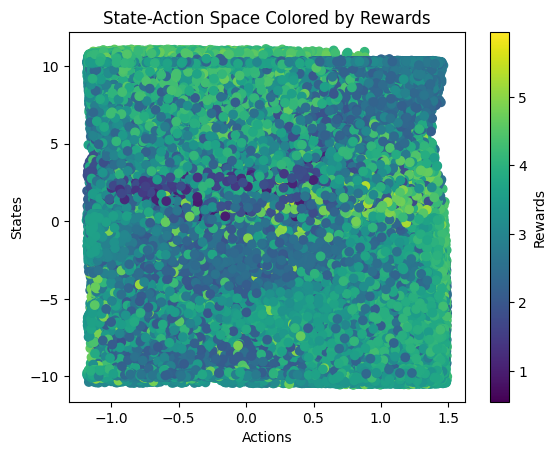

Original dataset size: 1000000


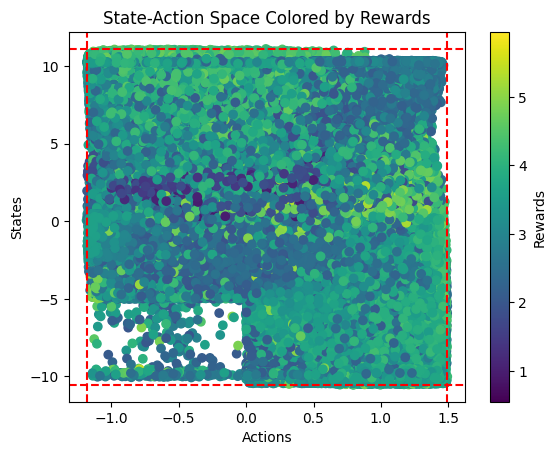

966248


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

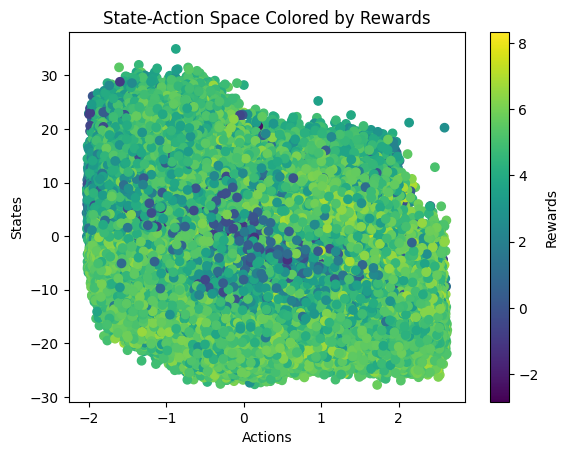

Original dataset size: 1000000


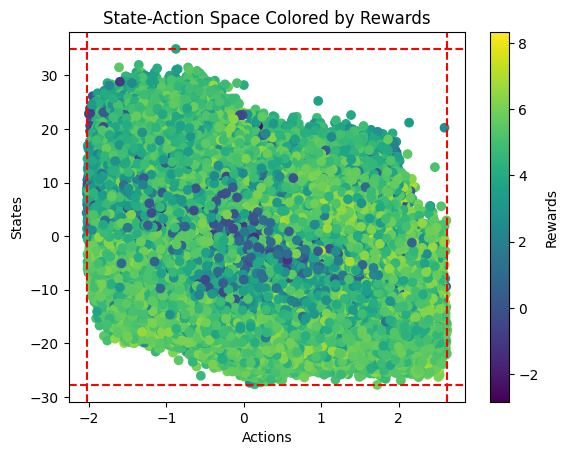

970610


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

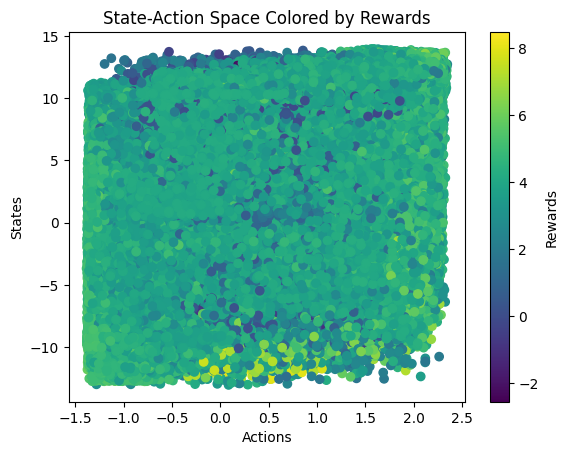

Original dataset size: 1000000


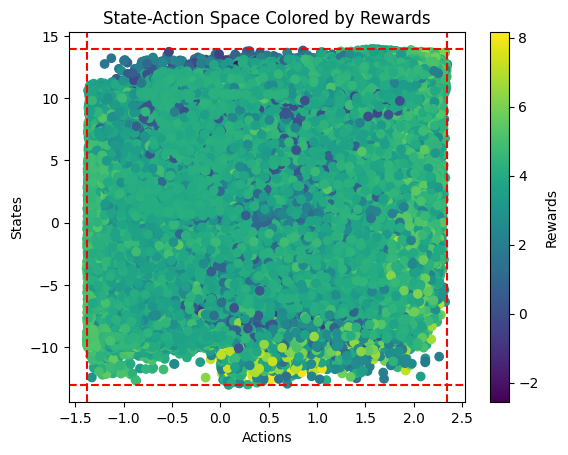

972494


In [34]:
hopper_d = reduce_and_plot('hopper-medium-v2', limits= [-5, 0])
halfcheetah_d = reduce_and_plot('halfcheetah-medium-v2', limits = [-20, 0])
walker2d_d  = reduce_and_plot('walker2d-medium-v2', limits = [-10, 0])


import pickle
with open('../../public/sparse_d4rl/hopper-medium-v2.pkl', 'wb') as f:
    pickle.dump(hopper_d, f)
with open('../../public/sparse_d4rl/halfcheetah-medium-v2.pkl', 'wb') as f:
    pickle.dump(halfcheetah_d, f)
with open('../../public/sparse_d4rl/walker2d-medium-v2.pkl', 'wb') as f:
    pickle.dump(walker2d_d, f)